# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

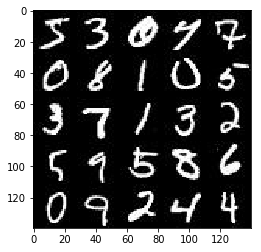

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

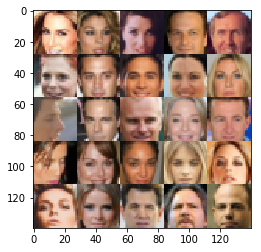

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [10]:
def lrelu(x, alpha):
    return tf.maximum(x * alpha, x)

In [13]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    kinit = tf.random_normal_initializer(stddev = 0.02)
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # 28 x 28 x 3 input
        x = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        # 14 x 14 x 64
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=True)
        # 7 x 7 x 128
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=True)
        # 4 x 4 x 256
        
        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)
        

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    kinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        #7 x 7 x 256
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 14 x 14 x 128
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, kernel_initializer = kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 28 x 28 x 64
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, kernel_initializer=kinit, padding='same')
        # 28 x 28 x 3
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_real_out, d_real_logits = discriminator(input_real, alpha=alpha)
    d_fake_out, d_fake_logits = discriminator(g_model, reuse=True, alpha=alpha)
    
    smooth= 0.1
    
    real_labels = tf.ones_like(d_real_out) * (1-smooth)
    fake_labels = tf.zeros_like(d_fake_out)
    g_labels = tf.ones_like(d_fake_out)
    
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=real_labels))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=fake_labels))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= d_fake_logits, labels = g_labels))
    
    d_loss = (d_real_loss) + (d_fake_loss)
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
   # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9919... Generator Loss: 0.9679
Epoch 1/2... Discriminator Loss: 0.5509... Generator Loss: 2.0462
Epoch 1/2... Discriminator Loss: 0.4973... Generator Loss: 2.6399
Epoch 1/2... Discriminator Loss: 0.4060... Generator Loss: 3.1479
Epoch 1/2... Discriminator Loss: 0.3903... Generator Loss: 3.5419
Epoch 1/2... Discriminator Loss: 0.5273... Generator Loss: 3.4027
Epoch 1/2... Discriminator Loss: 0.3702... Generator Loss: 3.9355
Epoch 1/2... Discriminator Loss: 0.3731... Generator Loss: 4.4539
Epoch 1/2... Discriminator Loss: 0.3688... Generator Loss: 3.9633
Epoch 1/2... Discriminator Loss: 0.3926... Generator Loss: 4.5552


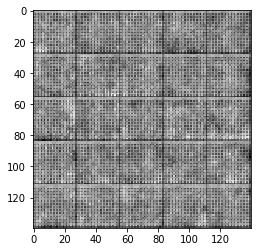

Epoch 1/2... Discriminator Loss: 0.3552... Generator Loss: 4.1447
Epoch 1/2... Discriminator Loss: 0.3812... Generator Loss: 4.4526
Epoch 1/2... Discriminator Loss: 0.3851... Generator Loss: 3.9468
Epoch 1/2... Discriminator Loss: 0.3737... Generator Loss: 4.3894
Epoch 1/2... Discriminator Loss: 0.3876... Generator Loss: 3.7260
Epoch 1/2... Discriminator Loss: 0.4341... Generator Loss: 3.6436
Epoch 1/2... Discriminator Loss: 0.3837... Generator Loss: 3.8880
Epoch 1/2... Discriminator Loss: 0.7200... Generator Loss: 2.6892
Epoch 1/2... Discriminator Loss: 0.3627... Generator Loss: 4.0974
Epoch 1/2... Discriminator Loss: 0.5723... Generator Loss: 6.5209


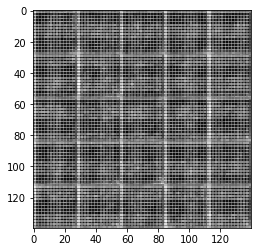

Epoch 1/2... Discriminator Loss: 0.4543... Generator Loss: 4.6554
Epoch 1/2... Discriminator Loss: 0.4892... Generator Loss: 2.2220
Epoch 1/2... Discriminator Loss: 0.5399... Generator Loss: 2.2132
Epoch 1/2... Discriminator Loss: 0.6194... Generator Loss: 1.6607
Epoch 1/2... Discriminator Loss: 0.4112... Generator Loss: 3.0292
Epoch 1/2... Discriminator Loss: 0.3941... Generator Loss: 3.6148
Epoch 1/2... Discriminator Loss: 1.0263... Generator Loss: 3.6335
Epoch 1/2... Discriminator Loss: 0.8019... Generator Loss: 1.1659
Epoch 1/2... Discriminator Loss: 0.4930... Generator Loss: 2.6321
Epoch 1/2... Discriminator Loss: 0.7294... Generator Loss: 1.3989


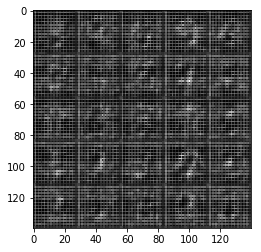

Epoch 1/2... Discriminator Loss: 0.5837... Generator Loss: 1.8184
Epoch 1/2... Discriminator Loss: 0.7696... Generator Loss: 1.2536
Epoch 1/2... Discriminator Loss: 0.6715... Generator Loss: 3.0620
Epoch 1/2... Discriminator Loss: 0.5166... Generator Loss: 2.6437
Epoch 1/2... Discriminator Loss: 0.5850... Generator Loss: 2.2864
Epoch 1/2... Discriminator Loss: 0.6408... Generator Loss: 1.7043
Epoch 1/2... Discriminator Loss: 0.7371... Generator Loss: 1.2215
Epoch 1/2... Discriminator Loss: 0.6204... Generator Loss: 1.6824
Epoch 1/2... Discriminator Loss: 0.7837... Generator Loss: 1.8989
Epoch 1/2... Discriminator Loss: 0.7460... Generator Loss: 1.4694


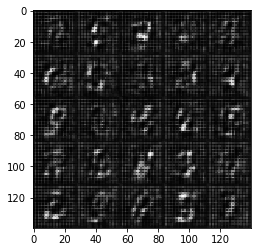

Epoch 1/2... Discriminator Loss: 0.6788... Generator Loss: 1.5854
Epoch 1/2... Discriminator Loss: 0.7128... Generator Loss: 2.0139
Epoch 1/2... Discriminator Loss: 0.9272... Generator Loss: 2.7018
Epoch 1/2... Discriminator Loss: 0.7365... Generator Loss: 1.4459
Epoch 1/2... Discriminator Loss: 0.6265... Generator Loss: 1.7410
Epoch 1/2... Discriminator Loss: 0.6954... Generator Loss: 1.7052
Epoch 1/2... Discriminator Loss: 0.7312... Generator Loss: 1.4985
Epoch 1/2... Discriminator Loss: 0.7542... Generator Loss: 1.3384
Epoch 1/2... Discriminator Loss: 1.0839... Generator Loss: 0.7471
Epoch 1/2... Discriminator Loss: 0.7403... Generator Loss: 1.3416


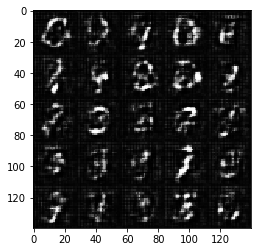

Epoch 1/2... Discriminator Loss: 0.6944... Generator Loss: 1.8972
Epoch 1/2... Discriminator Loss: 0.6322... Generator Loss: 1.7537
Epoch 1/2... Discriminator Loss: 0.7771... Generator Loss: 2.6341
Epoch 1/2... Discriminator Loss: 0.6572... Generator Loss: 1.5534
Epoch 1/2... Discriminator Loss: 0.9055... Generator Loss: 2.8855
Epoch 1/2... Discriminator Loss: 0.9496... Generator Loss: 1.0060
Epoch 1/2... Discriminator Loss: 0.9434... Generator Loss: 0.9137
Epoch 1/2... Discriminator Loss: 0.6559... Generator Loss: 1.6327
Epoch 1/2... Discriminator Loss: 0.7911... Generator Loss: 1.1819
Epoch 1/2... Discriminator Loss: 0.5952... Generator Loss: 2.1527


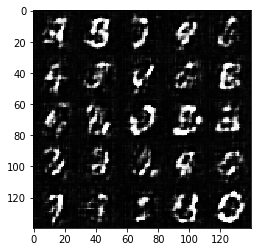

Epoch 1/2... Discriminator Loss: 0.7406... Generator Loss: 1.3484
Epoch 1/2... Discriminator Loss: 0.6359... Generator Loss: 1.5903
Epoch 1/2... Discriminator Loss: 0.8839... Generator Loss: 0.9817
Epoch 1/2... Discriminator Loss: 0.5853... Generator Loss: 1.8228
Epoch 1/2... Discriminator Loss: 0.7603... Generator Loss: 1.2370
Epoch 1/2... Discriminator Loss: 0.6394... Generator Loss: 1.9012
Epoch 1/2... Discriminator Loss: 0.6665... Generator Loss: 1.8601
Epoch 1/2... Discriminator Loss: 0.7254... Generator Loss: 1.9329
Epoch 1/2... Discriminator Loss: 0.6949... Generator Loss: 1.4167
Epoch 1/2... Discriminator Loss: 0.6990... Generator Loss: 1.5292


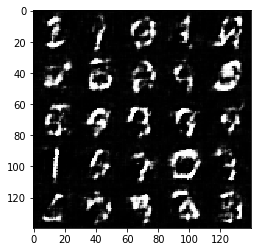

Epoch 1/2... Discriminator Loss: 1.6754... Generator Loss: 0.5156
Epoch 1/2... Discriminator Loss: 0.8232... Generator Loss: 1.1632
Epoch 1/2... Discriminator Loss: 0.6190... Generator Loss: 1.8408
Epoch 1/2... Discriminator Loss: 0.6946... Generator Loss: 2.4429
Epoch 1/2... Discriminator Loss: 0.7051... Generator Loss: 2.4680
Epoch 1/2... Discriminator Loss: 0.7333... Generator Loss: 1.7773
Epoch 1/2... Discriminator Loss: 1.0650... Generator Loss: 0.8436
Epoch 1/2... Discriminator Loss: 1.5101... Generator Loss: 0.4707
Epoch 1/2... Discriminator Loss: 0.9357... Generator Loss: 0.9981
Epoch 1/2... Discriminator Loss: 1.0079... Generator Loss: 0.8935


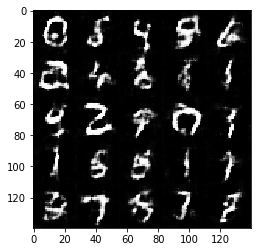

Epoch 1/2... Discriminator Loss: 0.7326... Generator Loss: 1.7726
Epoch 1/2... Discriminator Loss: 0.8974... Generator Loss: 1.8544
Epoch 1/2... Discriminator Loss: 0.7626... Generator Loss: 1.5427
Epoch 1/2... Discriminator Loss: 0.8196... Generator Loss: 2.5712
Epoch 1/2... Discriminator Loss: 0.7021... Generator Loss: 1.5352
Epoch 1/2... Discriminator Loss: 1.0670... Generator Loss: 1.1338
Epoch 1/2... Discriminator Loss: 1.1948... Generator Loss: 1.9134
Epoch 1/2... Discriminator Loss: 0.8385... Generator Loss: 1.1761
Epoch 1/2... Discriminator Loss: 0.7274... Generator Loss: 1.6035
Epoch 1/2... Discriminator Loss: 0.8311... Generator Loss: 1.5974


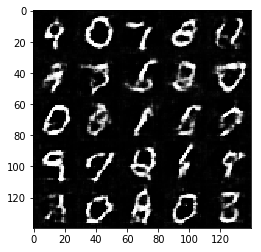

Epoch 1/2... Discriminator Loss: 0.8908... Generator Loss: 1.0023
Epoch 1/2... Discriminator Loss: 0.7666... Generator Loss: 1.3423
Epoch 1/2... Discriminator Loss: 1.0282... Generator Loss: 0.8347
Epoch 2/2... Discriminator Loss: 0.8899... Generator Loss: 1.0277
Epoch 2/2... Discriminator Loss: 0.7616... Generator Loss: 1.4043
Epoch 2/2... Discriminator Loss: 0.8472... Generator Loss: 1.0905
Epoch 2/2... Discriminator Loss: 1.2560... Generator Loss: 2.4326
Epoch 2/2... Discriminator Loss: 0.9318... Generator Loss: 1.0435
Epoch 2/2... Discriminator Loss: 0.8274... Generator Loss: 1.2885
Epoch 2/2... Discriminator Loss: 1.0502... Generator Loss: 2.0075


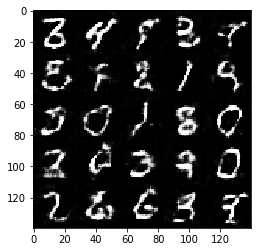

Epoch 2/2... Discriminator Loss: 0.7475... Generator Loss: 1.6856
Epoch 2/2... Discriminator Loss: 0.7316... Generator Loss: 1.5858
Epoch 2/2... Discriminator Loss: 0.7792... Generator Loss: 1.5664
Epoch 2/2... Discriminator Loss: 0.8538... Generator Loss: 1.1345
Epoch 2/2... Discriminator Loss: 0.7813... Generator Loss: 1.4612
Epoch 2/2... Discriminator Loss: 0.8780... Generator Loss: 1.1538
Epoch 2/2... Discriminator Loss: 0.8188... Generator Loss: 1.3703
Epoch 2/2... Discriminator Loss: 1.0364... Generator Loss: 0.8509
Epoch 2/2... Discriminator Loss: 0.8473... Generator Loss: 1.4307
Epoch 2/2... Discriminator Loss: 0.9108... Generator Loss: 1.1572


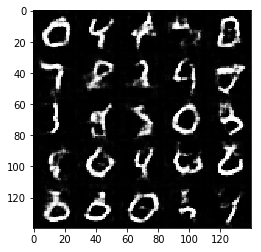

Epoch 2/2... Discriminator Loss: 0.7744... Generator Loss: 1.6180
Epoch 2/2... Discriminator Loss: 0.7484... Generator Loss: 1.8181
Epoch 2/2... Discriminator Loss: 0.7583... Generator Loss: 1.6024
Epoch 2/2... Discriminator Loss: 1.0150... Generator Loss: 1.8421
Epoch 2/2... Discriminator Loss: 0.9700... Generator Loss: 1.0417
Epoch 2/2... Discriminator Loss: 0.7975... Generator Loss: 1.6327
Epoch 2/2... Discriminator Loss: 0.9067... Generator Loss: 1.1357
Epoch 2/2... Discriminator Loss: 1.1479... Generator Loss: 0.7384
Epoch 2/2... Discriminator Loss: 0.8961... Generator Loss: 1.1102
Epoch 2/2... Discriminator Loss: 0.8202... Generator Loss: 1.3241


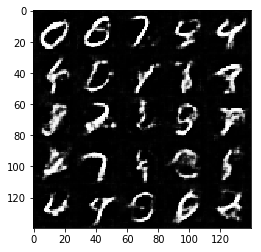

Epoch 2/2... Discriminator Loss: 0.8259... Generator Loss: 1.8943
Epoch 2/2... Discriminator Loss: 1.1920... Generator Loss: 2.5046
Epoch 2/2... Discriminator Loss: 1.0503... Generator Loss: 0.8729
Epoch 2/2... Discriminator Loss: 0.8452... Generator Loss: 1.2225
Epoch 2/2... Discriminator Loss: 1.0814... Generator Loss: 2.0247
Epoch 2/2... Discriminator Loss: 0.8426... Generator Loss: 1.4035
Epoch 2/2... Discriminator Loss: 1.1647... Generator Loss: 0.6784
Epoch 2/2... Discriminator Loss: 0.9819... Generator Loss: 0.8869
Epoch 2/2... Discriminator Loss: 1.0946... Generator Loss: 2.5182
Epoch 2/2... Discriminator Loss: 0.9407... Generator Loss: 1.2146


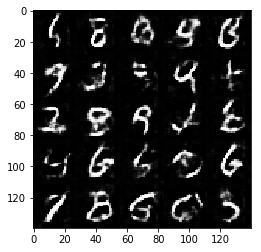

Epoch 2/2... Discriminator Loss: 0.8126... Generator Loss: 1.3181
Epoch 2/2... Discriminator Loss: 1.1677... Generator Loss: 1.6381
Epoch 2/2... Discriminator Loss: 0.8125... Generator Loss: 1.3878
Epoch 2/2... Discriminator Loss: 0.8607... Generator Loss: 1.3039
Epoch 2/2... Discriminator Loss: 0.8674... Generator Loss: 1.2234
Epoch 2/2... Discriminator Loss: 0.9267... Generator Loss: 1.0379
Epoch 2/2... Discriminator Loss: 1.0559... Generator Loss: 2.6483
Epoch 2/2... Discriminator Loss: 0.8066... Generator Loss: 1.6456
Epoch 2/2... Discriminator Loss: 0.9169... Generator Loss: 1.9020
Epoch 2/2... Discriminator Loss: 0.8349... Generator Loss: 1.3854


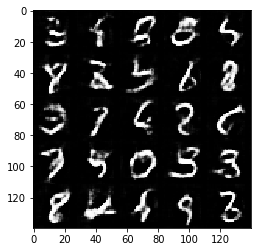

Epoch 2/2... Discriminator Loss: 0.9010... Generator Loss: 1.0420
Epoch 2/2... Discriminator Loss: 0.9165... Generator Loss: 1.7606
Epoch 2/2... Discriminator Loss: 0.9220... Generator Loss: 1.1344
Epoch 2/2... Discriminator Loss: 0.6615... Generator Loss: 1.7107
Epoch 2/2... Discriminator Loss: 0.9581... Generator Loss: 1.9028
Epoch 2/2... Discriminator Loss: 0.8201... Generator Loss: 1.4850
Epoch 2/2... Discriminator Loss: 0.8654... Generator Loss: 1.2052
Epoch 2/2... Discriminator Loss: 0.8704... Generator Loss: 1.0319
Epoch 2/2... Discriminator Loss: 0.7235... Generator Loss: 1.6819
Epoch 2/2... Discriminator Loss: 0.7636... Generator Loss: 1.4413


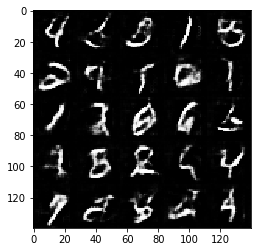

Epoch 2/2... Discriminator Loss: 0.9521... Generator Loss: 0.9968
Epoch 2/2... Discriminator Loss: 0.8582... Generator Loss: 1.0410
Epoch 2/2... Discriminator Loss: 0.6629... Generator Loss: 1.8238
Epoch 2/2... Discriminator Loss: 0.7935... Generator Loss: 1.9859
Epoch 2/2... Discriminator Loss: 0.9269... Generator Loss: 1.0314
Epoch 2/2... Discriminator Loss: 1.1706... Generator Loss: 2.5195
Epoch 2/2... Discriminator Loss: 0.9185... Generator Loss: 1.2185
Epoch 2/2... Discriminator Loss: 0.7771... Generator Loss: 1.2546
Epoch 2/2... Discriminator Loss: 1.0082... Generator Loss: 0.9972
Epoch 2/2... Discriminator Loss: 0.6723... Generator Loss: 1.7087


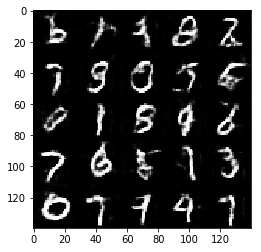

Epoch 2/2... Discriminator Loss: 0.8936... Generator Loss: 1.1005
Epoch 2/2... Discriminator Loss: 0.9622... Generator Loss: 1.7374
Epoch 2/2... Discriminator Loss: 1.0480... Generator Loss: 0.8390
Epoch 2/2... Discriminator Loss: 0.8096... Generator Loss: 1.7122
Epoch 2/2... Discriminator Loss: 0.7737... Generator Loss: 1.2620
Epoch 2/2... Discriminator Loss: 0.7475... Generator Loss: 1.6486
Epoch 2/2... Discriminator Loss: 0.7048... Generator Loss: 1.6467
Epoch 2/2... Discriminator Loss: 0.8064... Generator Loss: 1.9509
Epoch 2/2... Discriminator Loss: 0.9522... Generator Loss: 0.9387
Epoch 2/2... Discriminator Loss: 1.2123... Generator Loss: 0.6555


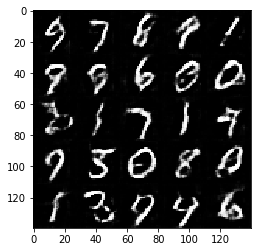

Epoch 2/2... Discriminator Loss: 0.8912... Generator Loss: 1.0664
Epoch 2/2... Discriminator Loss: 1.0889... Generator Loss: 0.7957
Epoch 2/2... Discriminator Loss: 0.9382... Generator Loss: 0.9618
Epoch 2/2... Discriminator Loss: 0.8568... Generator Loss: 1.1243
Epoch 2/2... Discriminator Loss: 0.7456... Generator Loss: 1.5216
Epoch 2/2... Discriminator Loss: 0.7961... Generator Loss: 1.2170
Epoch 2/2... Discriminator Loss: 0.7467... Generator Loss: 1.8763
Epoch 2/2... Discriminator Loss: 1.0012... Generator Loss: 0.9585
Epoch 2/2... Discriminator Loss: 0.5410... Generator Loss: 2.1243
Epoch 2/2... Discriminator Loss: 0.7580... Generator Loss: 1.9675


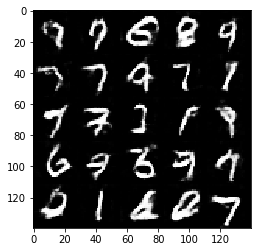

Epoch 2/2... Discriminator Loss: 0.8739... Generator Loss: 1.4015
Epoch 2/2... Discriminator Loss: 1.0585... Generator Loss: 0.8211
Epoch 2/2... Discriminator Loss: 0.8403... Generator Loss: 1.7406
Epoch 2/2... Discriminator Loss: 0.9069... Generator Loss: 1.0765
Epoch 2/2... Discriminator Loss: 0.7301... Generator Loss: 1.8078
Epoch 2/2... Discriminator Loss: 0.8091... Generator Loss: 1.4022
Epoch 2/2... Discriminator Loss: 0.7612... Generator Loss: 1.5124


In [28]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.3081... Generator Loss: 0.2440
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 0.4342
Epoch 1/1... Discriminator Loss: 0.6939... Generator Loss: 1.6716
Epoch 1/1... Discriminator Loss: 0.5299... Generator Loss: 2.1197
Epoch 1/1... Discriminator Loss: 0.4804... Generator Loss: 2.8260
Epoch 1/1... Discriminator Loss: 1.8979... Generator Loss: 8.1515
Epoch 1/1... Discriminator Loss: 0.4917... Generator Loss: 3.9046
Epoch 1/1... Discriminator Loss: 0.5118... Generator Loss: 2.8200
Epoch 1/1... Discriminator Loss: 1.5287... Generator Loss: 0.5076


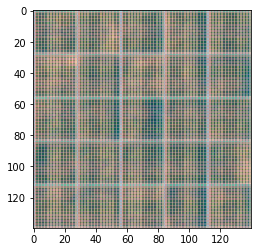

Epoch 1/1... Discriminator Loss: 2.8114... Generator Loss: 0.1196
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 1.2098
Epoch 1/1... Discriminator Loss: 2.2020... Generator Loss: 5.2364
Epoch 1/1... Discriminator Loss: 2.4425... Generator Loss: 0.1789
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 0.8039... Generator Loss: 1.3510
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.5398
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 2.4848


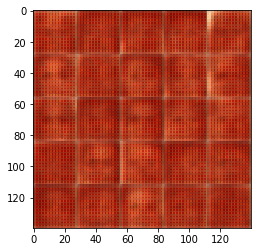

Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 1.5149
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 2.1788
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 0.9055
Epoch 1/1... Discriminator Loss: 2.0886... Generator Loss: 0.2671
Epoch 1/1... Discriminator Loss: 0.8327... Generator Loss: 1.3857
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.5138
Epoch 1/1... Discriminator Loss: 2.1042... Generator Loss: 0.2748
Epoch 1/1... Discriminator Loss: 1.5788... Generator Loss: 0.5368


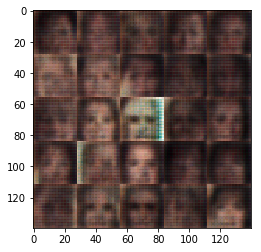

Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 1.2334
Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 1.0825
Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 1.2062
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 1.3390
Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 1.1688
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.4720
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 1.3038
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 1.2712


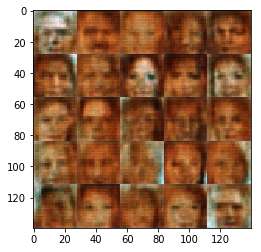

Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 1.0304
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 0.9233... Generator Loss: 1.7424
Epoch 1/1... Discriminator Loss: 1.6320... Generator Loss: 2.3068
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 1.2723
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.9895
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 1.9340


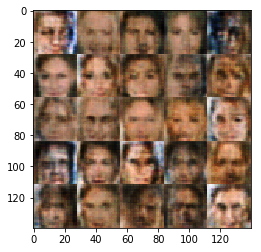

Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 1.0157
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.6125... Generator Loss: 0.4250
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.5320


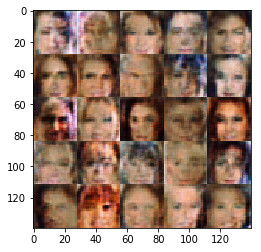

Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 1.0099
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 1.0997
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.5346
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.8137


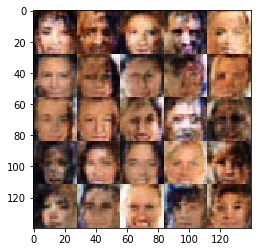

Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 1.3047
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 0.9384


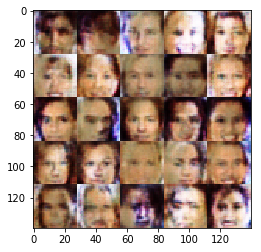

Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 1.0665
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 1.2703
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 1.2174
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 1.1641
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 1.5552
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.7041


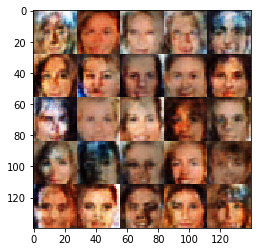

Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 1.0846
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 1.1164
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 1.2457
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.9693


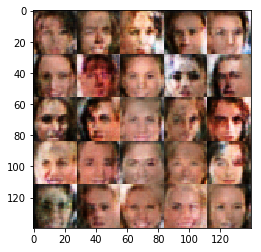

Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 1.0197
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 1.2216
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 1.3668
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 1.1036
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.6121


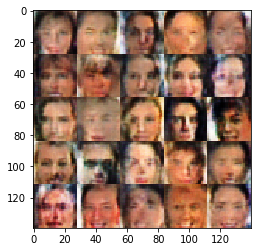

Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 1.0369
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.5708
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.7919


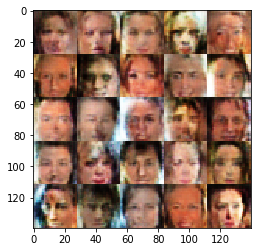

Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 1.1337
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 1.0687
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 1.6431
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.5081


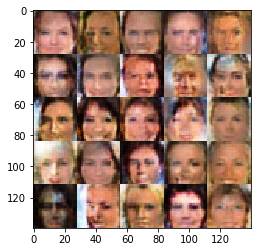

Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 0.8656... Generator Loss: 1.7189
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 1.1436
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.6080


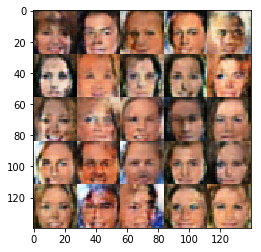

Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.5833... Generator Loss: 0.4564
Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 1.0528


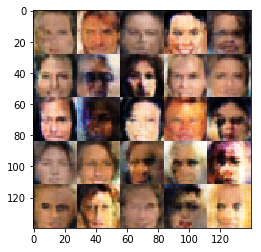

Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 1.0261
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 1.1726
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.7905... Generator Loss: 0.3203


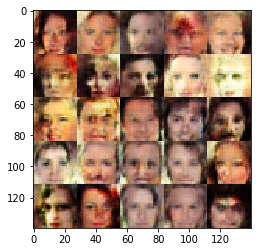

Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.4971
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.5593
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 1.0280


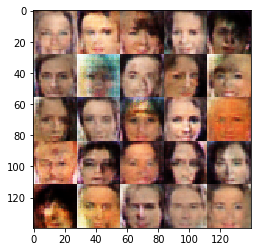

Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.5089
Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 0.9953


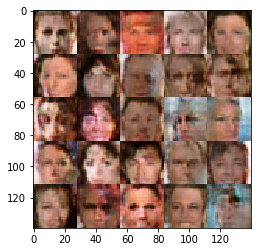

Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 1.3952
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 1.1388
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 1.0460
Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 1.2906
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 0.9821
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.8825


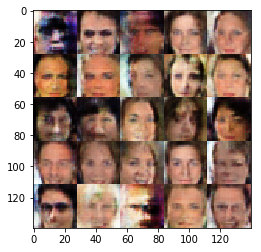

Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.5210... Generator Loss: 0.4450
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 1.1742
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 1.2347
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 1.0934


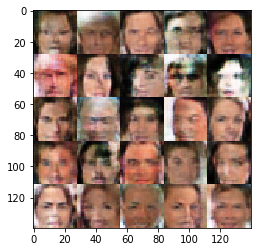

Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 1.6200
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.5790
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 1.2392
Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.6042


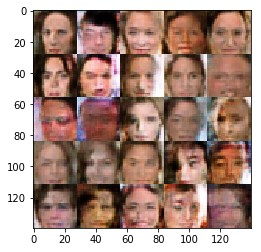

Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.9849
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.5323
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 1.0550
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.5904
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.5228
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.1387


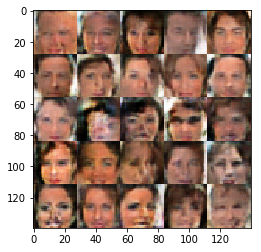

Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 1.1782
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 0.9523
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 1.1840
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 1.1621


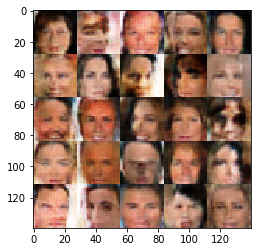

Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.5426... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.4900
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.8555... Generator Loss: 0.2824
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 1.0363


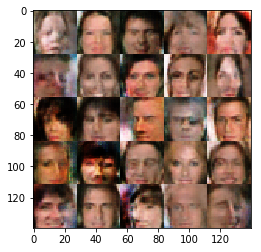

Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.5069
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.5332
Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 1.1625
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.8855


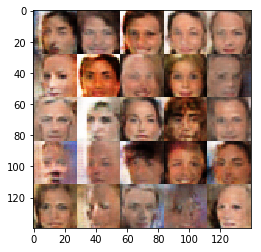

Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 1.2555
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 1.0849
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.5642
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.5293
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 1.1018
Epoch 1/1... Discriminator Loss: 1.0245... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 1.5185... Generator Loss: 0.4538


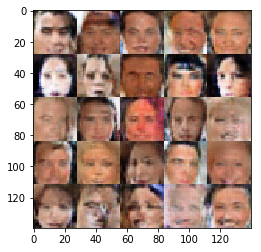

Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 0.9889
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 1.2318


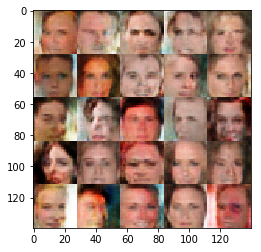

Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 1.0198
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.8932


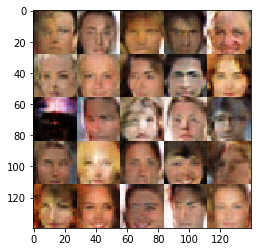

Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.6381... Generator Loss: 0.3903
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 1.0459
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 1.1540


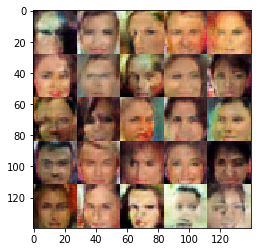

Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 1.0784
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.6665


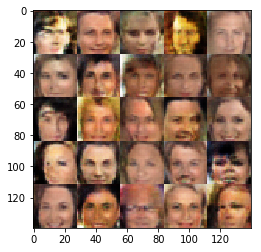

Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 1.0338
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.5124
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 1.2108
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 0.9408


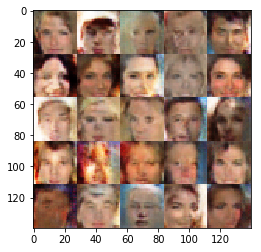

Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.5364
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.4594
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.6375


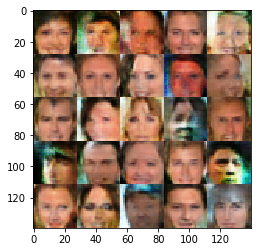

Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.4481
Epoch 1/1... Discriminator Loss: 1.5299... Generator Loss: 0.4299
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.5690


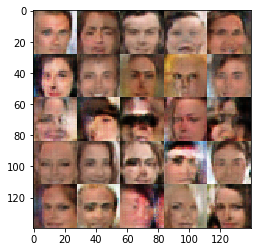

Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 1.1699
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.5770... Generator Loss: 0.4130
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.4447
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.8035


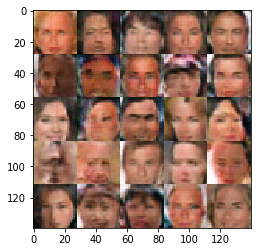

Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 0.9838


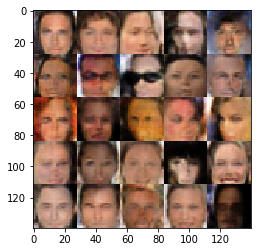

Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.4573
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 0.8579


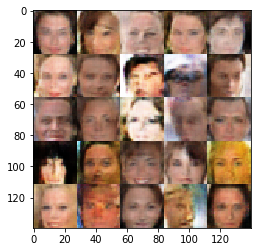

Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 1.0841
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 1.0313
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 1.0967


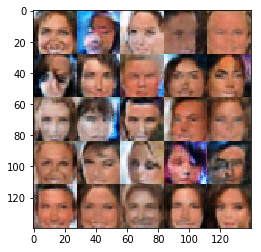

Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.5551
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 1.2226


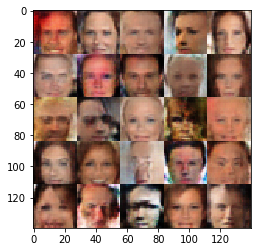

Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 1.1193
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 1.6574... Generator Loss: 0.4277
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 1.0807


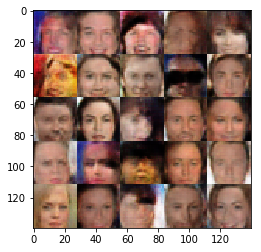

Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.5420
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.6082


In [29]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.